## **Importing dependencies**

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torchvision
import tarfile
from zipfile import ZipFile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torchvision.models import ResNet50_Weights
torchvision.__version__

'0.13.0+cu113'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
with ZipFile('/content/drive/MyDrive/custom_dataset.zip', 'r') as zip:
    zip.extractall(path='./data')

In [5]:
dir_path='./data/dataset/'
folders= os.listdir(dir_path)
print(folders)
for i in folders:
  print(os.listdir(dir_path+'/'+i))

['validation_data', 'training_data']
['notsmoking', 'smoking']
['notsmoking', 'smoking']


In [6]:
input_path = "./data/dataset/"

## **Creating pyTorch generators**

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'training_data':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation_data':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'training_data': 
    datasets.ImageFolder(input_path + 'training_data', data_transforms['training_data']),
    'validation_data': 
    datasets.ImageFolder(input_path + 'validation_data/', data_transforms['validation_data'])
}

dataloaders = {
    'training_data':
    torch.utils.data.DataLoader(image_datasets['training_data'],
                                batch_size=32,
                                shuffle=True), 
    'validation_data':
    torch.utils.data.DataLoader(image_datasets['validation_data'],
                                batch_size=32,
                                shuffle=False,) 
}

## **Creating the network**

In [8]:
model = models.resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

## **Training the model**

In [10]:
def train_model(model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['training_data', 'validation_data']:
            if phase == 'training_data':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'training_data':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [11]:
model_trained = train_model(model, criterion, optimizer, num_epochs=100)

Epoch 1/100
----------
training_data loss: 0.6065, acc: 0.7375
validation_data loss: 0.3753, acc: 0.9500
Epoch 2/100
----------
training_data loss: 0.3831, acc: 0.8938
validation_data loss: 0.1627, acc: 1.0000
Epoch 3/100
----------
training_data loss: 0.2046, acc: 0.9625
validation_data loss: 0.1197, acc: 1.0000
Epoch 4/100
----------
training_data loss: 0.1529, acc: 0.9750
validation_data loss: 0.0722, acc: 1.0000
Epoch 5/100
----------
training_data loss: 0.1023, acc: 0.9750
validation_data loss: 0.0561, acc: 1.0000
Epoch 6/100
----------
training_data loss: 0.0586, acc: 0.9813
validation_data loss: 0.0507, acc: 1.0000
Epoch 7/100
----------
training_data loss: 0.0792, acc: 0.9813
validation_data loss: 0.0569, acc: 1.0000
Epoch 8/100
----------
training_data loss: 0.0356, acc: 0.9938
validation_data loss: 0.0393, acc: 1.0000
Epoch 9/100
----------
training_data loss: 0.0445, acc: 0.9938
validation_data loss: 0.0367, acc: 1.0000
Epoch 10/100
----------
training_data loss: 0.0197, acc

## **Save and load the model**

In [12]:
!mkdir models
!mkdir models/pytorch

In [13]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [14]:
model = models.resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

<All keys matched successfully>

## **Making predictions**

In [18]:
validation_img_paths = ["validation_data/notsmoking/100.jpg",
                        "validation_data/smoking/23.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [19]:
validation_batch = torch.stack([data_transforms['validation_data'](img).to(device)
                                for img in img_list])

In [20]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 2.2574, -2.3248],
        [-3.2649,  3.0086]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [21]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.98987156, 0.0101285 ],
       [0.0018822 , 0.9981178 ]], dtype=float32)

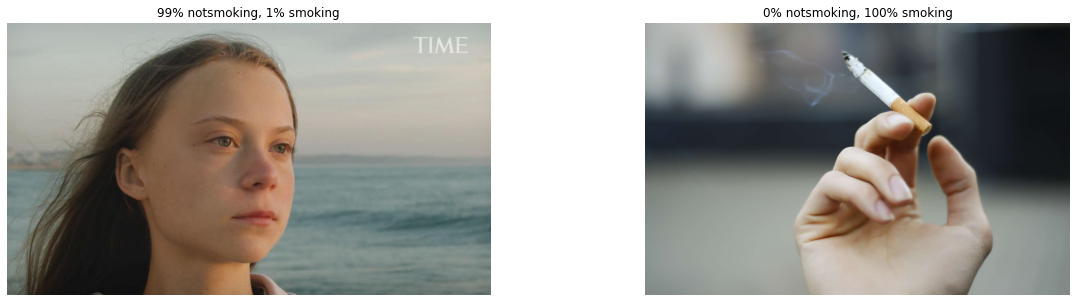

In [22]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% notsmoking, {:.0f}% smoking".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)